# Chemical Reactor 

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_reactor.py).This example demonstrates a **Continuous Stirred Tank Reactor (CSTR)** with consecutive exothermic reactions. This is a classic **stiff ODE system** that requires specialized solvers for efficient simulation.

## Chemical Reaction System

The reactor contains two consecutive reactions:

$$A \xrightarrow{k_1} B \xrightarrow{k_2} C$$

Both reactions are:
- **Exothermic** (release heat)
- **Temperature-dependent** (Arrhenius kinetics)
- **Highly nonlinear**

## Mathematical Model

The system is described by three ODEs:

### Concentration of A:
$$\frac{dC_A}{dt} = \frac{C_{A,in} - C_A}{\tau} - k_1 e^{-E_1/(RT)} C_A$$

### Concentration of B:
$$\frac{dC_B}{dt} = \frac{-C_B}{\tau} + k_1 e^{-E_1/(RT)} C_A - k_2 e^{-E_2/(RT)} C_B$$

### Reactor Temperature:
$$\frac{dT}{dt} = \frac{T_{in} - T}{\tau} + \frac{-\Delta H_1}{\rho C_p} k_1 e^{-E_1/(RT)} C_A + \frac{-\Delta H_2}{\rho C_p} k_2 e^{-E_2/(RT)} C_B - \frac{UA(T-T_c)}{V\rho C_p}$$

## Why is this System Stiff?

The system is **stiff** because:
1. **Exponential temperature dependence** creates vastly different timescales
2. **Fast reactions** (high $k$ values) vs. **slow heat transfer**
3. **Tight coupling** between concentration and temperature

Standard explicit solvers would require extremely small timesteps. We use **GEAR52A**, an implicit solver designed for stiff systems.

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style for consistent, theme-friendly figures
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import ODE, Source, Scope
from pathsim.solvers import GEAR52A

## System Parameters

We define the physical and chemical parameters for the reactor.

In [31]:
# Initial conditions
Ca_0 = 1.0    # Initial concentration of A [mol/L]
Cb_0 = 0.0    # Initial concentration of B [mol/L]
T_0 = 300.0   # Initial temperature [K]

# System parameters
Tc = 280.0    # Coolant temperature [K]
tau = 1.0     # Residence time [s]
k1_0 = 1e4    # Pre-exponential factor 1 [1/s]
k2_0 = 1e3    # Pre-exponential factor 2 [1/s]
E1 = 5e4      # Activation energy 1 [J/mol]
E2 = 5.5e4    # Activation energy 2 [J/mol]
dH1 = -5e4    # Reaction enthalpy 1 [J/mol]
dH2 = -5.2e4  # Reaction enthalpy 2 [J/mol]
rho = 1000.0  # Density [kg/m³]
Cp = 4.184    # Heat capacity [J/(g·K)]
U = 1000.0    # Heat transfer coefficient [W/(m²·K)]
V = 0.1       # Reactor volume [m³]
A = 0.1       # Heat transfer area [m²]
R = 8.314     # Gas constant [J/(mol·K)]

## Input Signals

The feed concentration and temperature vary with time to simulate disturbances.

In [34]:
# Time-varying inputs
Src_Ca = Source(lambda t: 2.0 + np.sin(0.5*t))  # Feed concentration A
Src_T = Source(lambda t: 280.0 * (1 - 0.8 * np.exp(-0.6*t)))  # Feed temperature

## ODE Function

We define the right-hand side of the ODEs, implementing the reactor dynamics with Arrhenius kinetics.

In [37]:
def reaction_rates(x, u, t):
    """CSTR dynamics with consecutive reactions
    
    Parameters
    ----------
    x : array [Ca, Cb, T]
        State variables
    u : array [Ca_in, T_in]
        Input variables
    t : float
        Time
    
    Returns
    -------
    dx_dt : array
        Time derivatives
    """
    # Unpack states
    Ca, Cb, T = x
    
    # Unpack inputs
    Ca_in, T_in = u
    
    # Reaction rate constants (Arrhenius)
    k1 = k1_0 * np.exp(-E1/(R*T))
    k2 = k2_0 * np.exp(-E2/(R*T))
    
    # Concentration dynamics
    dCa_dt = (Ca_in - Ca)/tau - k1*Ca
    dCb_dt = -Cb/tau + k1*Ca - k2*Cb
    
    # Temperature dynamics
    Q_reaction1 = (-dH1/(rho*Cp)) * k1 * Ca
    Q_reaction2 = (-dH2/(rho*Cp)) * k2 * Cb
    Q_cooling = U*A*(T - Tc)/(V*rho*Cp)
    
    dT_dt = (T_in - T)/tau + Q_reaction1 + Q_reaction2 - Q_cooling
    
    return np.array([dCa_dt, dCb_dt, dT_dt])

## System Setup

We create the ODE block and scope for recording the state variables.

In [40]:
# Define system blocks
CSTR = ODE(reaction_rates, np.array([Ca_0, Cb_0, T_0]))
Sco = Scope(labels=['Ca', 'Cb', 'T'])

blocks = [CSTR, Src_Ca, Src_T, Sco]

connections = [
    Connection(CSTR, Sco),         # Ca output
    Connection(CSTR[1], Sco[1]),   # Cb output
    Connection(CSTR[2], Sco[2]),   # T output
    Connection(Src_Ca, CSTR[0]),   # Ca_in input
    Connection(Src_T, CSTR[1])     # T_in input
]

## Simulation with Stiff Solver

In [43]:
# Initialize simulation with stiff solver
Sim = Simulation(
    blocks,
    connections,
    dt=0.001,
    log=True,
    Solver=GEAR52A,
    tolerance_lte_abs=1e-6,
    tolerance_lte_rel=1e-4
)

# Run simulation for 20 seconds
Sim.run(20)

2025-10-09 20:44:51,912 - INFO - LOGGING (log: True)
2025-10-09 20:44:51,913 - INFO - BLOCK (type: ODE, dynamic: True, events: 0)
2025-10-09 20:44:51,913 - INFO - BLOCK (type: Source, dynamic: False, events: 0)
2025-10-09 20:44:51,914 - INFO - BLOCK (type: Source, dynamic: False, events: 0)
2025-10-09 20:44:51,914 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-09 20:44:51,914 - INFO - GRAPH (size: 4, alg. depth: 1, loop depth: 0, runtime: 0.061ms)
2025-10-09 20:44:51,915 - INFO - STARTING -> TRANSIENT (Duration: 20.00s)
2025-10-09 20:44:51,915 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-09 20:44:51,943 - INFO - TRANSIENT:  20% | elapsed: 00:00:00 (eta: --:--:--) | 26 steps (946.5 steps/s)
2025-10-09 20:44:51,951 - INFO - TRANSIENT:  41% | elapsed: 00:00:00 (eta: --:--:--) | 36 steps (1242.1 steps/s)
2025-10-09 20:44:51,958 - INFO - TRANSIENT:  62% | elapsed: 00:00:00 (eta: --:--:--) | 45 steps (1312.4 steps/s)
2025-10-09

{'total_steps': 59, 'successful_steps': 52, 'runtime_ms': 54.61749993264675}

## Results: Reactor Dynamics

The plots show:
- **Ca** (blue): Concentration of reactant A
- **Cb** (orange): Concentration of intermediate B
- **T** (green): Reactor temperature

Notice the complex dynamics with multiple timescales and the strong coupling between concentrations and temperature.

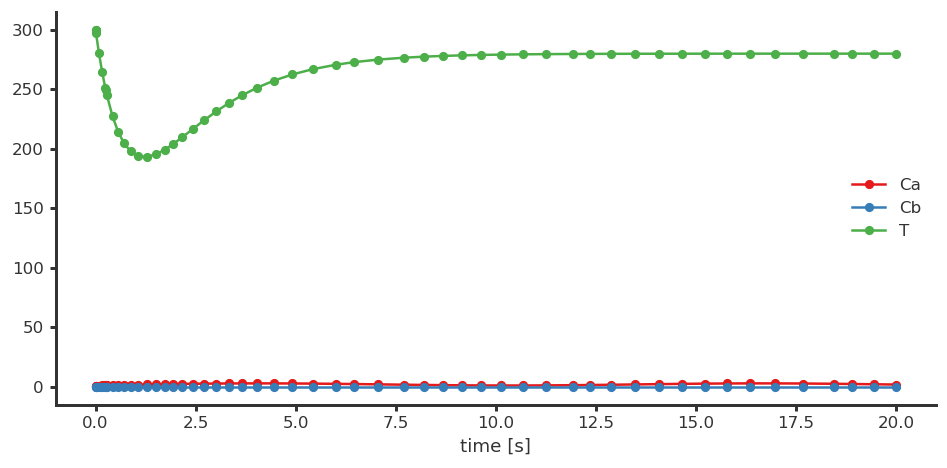

In [46]:
# Plot results
Sco.plot(".-", lw=1.5)
plt.show()

## Analysis: Phase Portrait

Let's examine the relationship between concentration and temperature in phase space.

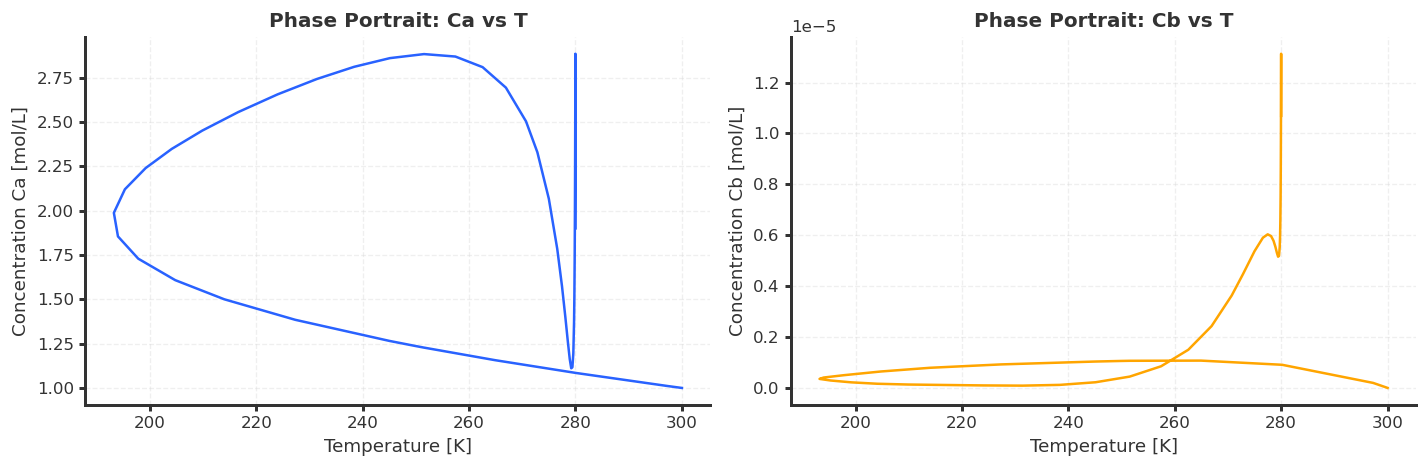

In [49]:
# Get simulation data
time, [Ca, Cb, T] = Sco.read()

# Phase portraits
fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=200)

# Ca vs T
axes[0].plot(T, Ca, linewidth=1.5)
axes[0].set_xlabel('Temperature [K]')
axes[0].set_ylabel('Concentration Ca [mol/L]')
axes[0].set_title('Phase Portrait: Ca vs T')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cb vs T
axes[1].plot(T, Cb, linewidth=1.5, color='orange')
axes[1].set_xlabel('Temperature [K]')
axes[1].set_ylabel('Concentration Cb [mol/L]')
axes[1].set_title('Phase Portrait: Cb vs T')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()